# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [22]:
# Imports
import torch
from torchvision import datasets, transforms
from torch import nn, optim, dropout
import torch.nn.functional as F
import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
print(len(trainloader), len(testloader))


938 157


In [4]:
# Lets manual define a class

class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__() # Inheritence of nn.Module
        # Define Strucuture
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,56)
        self.fc3 = nn.Linear(56,28)
        self.fc4 = nn.Linear(28,10)
        
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Pass structure into function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [5]:
model = Classifier()
images, labels = next(iter(testloader))
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [6]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])
print(top_p[:10,:])

tensor([[2],
        [2],
        [2],
        [5],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])
tensor([[0.1187],
        [0.1158],
        [0.1180],
        [0.1232],
        [0.1164],
        [0.1188],
        [0.1152],
        [0.1202],
        [0.1183],
        [0.1186]], grad_fn=<SliceBackward>)


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [7]:
equals = top_class == labels.view(*top_class.shape)
print(equals[:10])

tensor([[ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True]])


Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [8]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 15.625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    
    running_loss = 0
    
    for images, labels in trainloader:
        
        # Reset Stored Gradient
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        
        test_loss = 0
        accuracy = 0
        
        ## Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            # validation pass here
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
print("Done Training")

Epoch: 1/30..  Training Loss: 0.555..  Test Loss: 0.459..  Test Accuracy: 0.835
Epoch: 2/30..  Training Loss: 0.389..  Test Loss: 0.393..  Test Accuracy: 0.859
Epoch: 3/30..  Training Loss: 0.353..  Test Loss: 0.383..  Test Accuracy: 0.864
Epoch: 4/30..  Training Loss: 0.325..  Test Loss: 0.379..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.309..  Test Loss: 0.362..  Test Accuracy: 0.871
Epoch: 6/30..  Training Loss: 0.293..  Test Loss: 0.364..  Test Accuracy: 0.870
Epoch: 7/30..  Training Loss: 0.281..  Test Loss: 0.343..  Test Accuracy: 0.878
Epoch: 8/30..  Training Loss: 0.269..  Test Loss: 0.367..  Test Accuracy: 0.876
Epoch: 9/30..  Training Loss: 0.258..  Test Loss: 0.369..  Test Accuracy: 0.875
Epoch: 10/30..  Training Loss: 0.251..  Test Loss: 0.343..  Test Accuracy: 0.879
Epoch: 11/30..  Training Loss: 0.240..  Test Loss: 0.347..  Test Accuracy: 0.881
Epoch: 12/30..  Training Loss: 0.235..  Test Loss: 0.369..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.227.

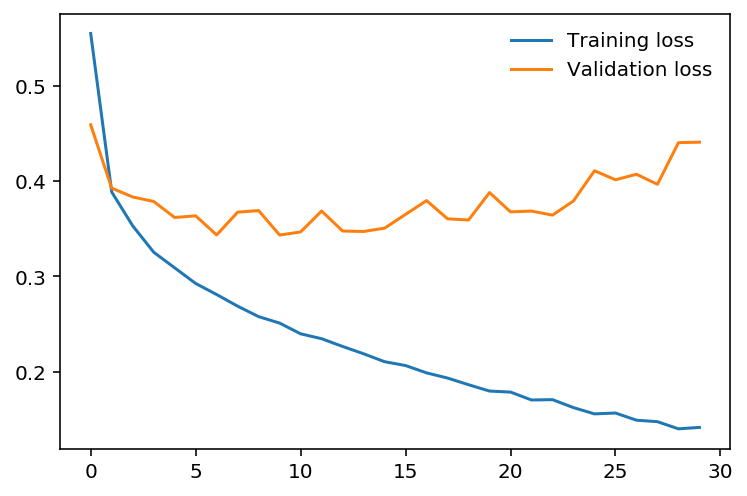

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. ***So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`.*** This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [18]:
class Classifier_Dropout(nn.Module):
    
    def __init__(self):
        super().__init__() # Inheritence of nn.Module
        # Define Strucuture
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,56)
        self.fc3 = nn.Linear(56,28)
        self.fc4 = nn.Linear(28,10)
        
        self.dropout = nn.Dropout(p= 0.2) # Probability of Dropout
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Pass structure into function w/ Dropout Layer after each hidden layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # No output on Dropout
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [21]:
#New Model
model = Classifier_Dropout()
criterion = nn.NLLLoss()  # Negative Loss Likelihood
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 30
steps = 0

for e in range(epochs):
    
    running_loss = 0
    
    # Look at each batch in trainloader
    for images, labels in trainloader:
        model.train()
        optimizer.zero_grad() #Reset Gradient Memory
        
        log_ps = model(images) # Image Reshape happens in pass
        loss = criterion(log_ps, labels)
        loss.backward() #Calculate Gradient
        optimizer.step() #Backpropagation
        running_loss += loss.item() # Store loss
        
    else:
        test_loss = 0
        accuracy = 0
        
        #Turn off back-pass
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()

            for images,labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss
                
                #Now calculate non-log output
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) #Grab max across rows
                #Compare out labels with each cross class, store as list of boolean
                equals = top_class == labels.view(*top_class.shape) 
                # Use mean as accuracy, must feed equals as FloatTensor
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
print("Done Training")


Epoch: 1/30..  Training Loss: 0.703..  Test Loss: 0.467..  Test Accuracy: 0.824
Epoch: 2/30..  Training Loss: 0.488..  Test Loss: 0.434..  Test Accuracy: 0.847
Epoch: 3/30..  Training Loss: 0.441..  Test Loss: 0.404..  Test Accuracy: 0.856
Epoch: 4/30..  Training Loss: 0.416..  Test Loss: 0.381..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.397..  Test Loss: 0.374..  Test Accuracy: 0.866
Epoch: 6/30..  Training Loss: 0.382..  Test Loss: 0.376..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.368..  Test Loss: 0.374..  Test Accuracy: 0.866
Epoch: 8/30..  Training Loss: 0.361..  Test Loss: 0.361..  Test Accuracy: 0.869
Epoch: 9/30..  Training Loss: 0.349..  Test Loss: 0.370..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.346..  Test Loss: 0.351..  Test Accuracy: 0.876
Epoch: 11/30..  Training Loss: 0.339..  Test Loss: 0.343..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.331..  Test Loss: 0.353..  Test Accuracy: 0.876
Epoch: 13/30..  Training Loss: 0.324.

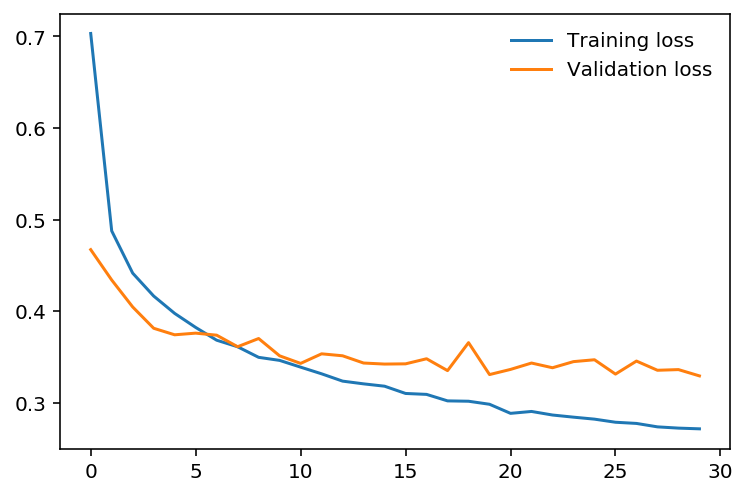

In [24]:
plt.plot(train_losses[30:], label='Training loss')
plt.plot(test_losses[30:], label='Validation loss')
plt.legend(frameon=False)

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

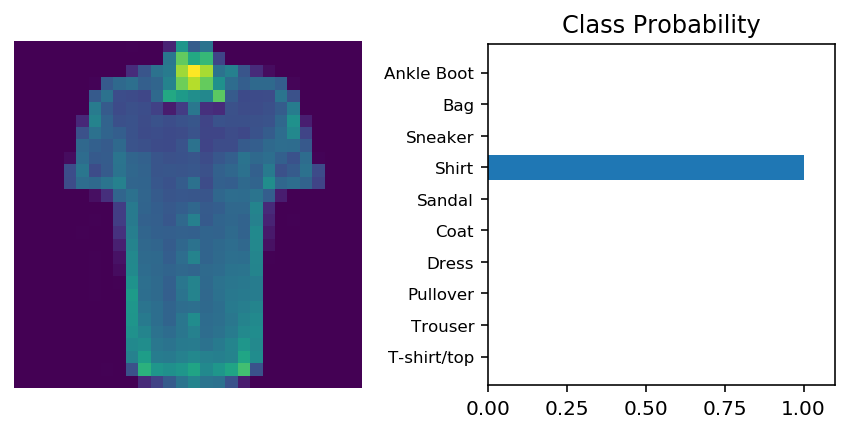

In [25]:
model.eval() # Switch to eval to turn off dropoff

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

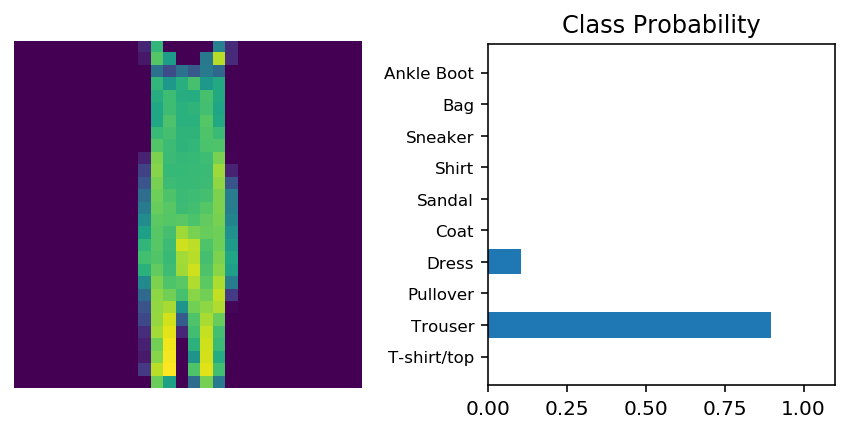

In [28]:
model.eval() # Switch to eval to turn off dropoff

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[3]
# Convert 2D image to 1D vector
img = img

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

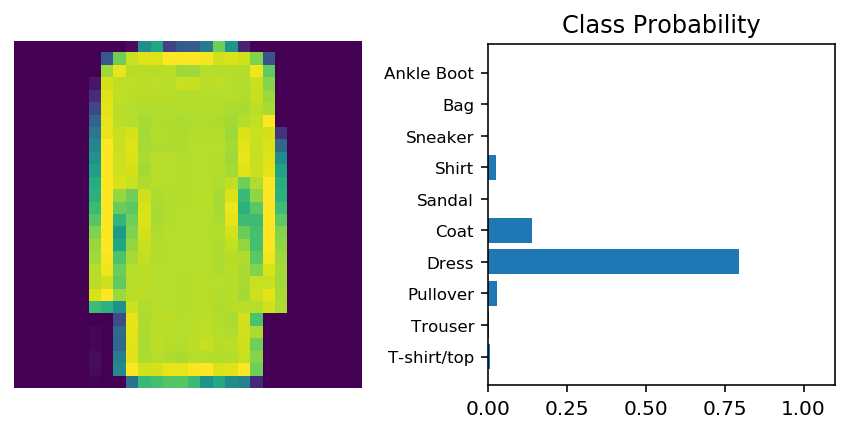

In [27]:
model.eval() # Switch to eval to turn off dropoff

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

# Saving Models
In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [29]:
import fc_model

Here we can see one of the images

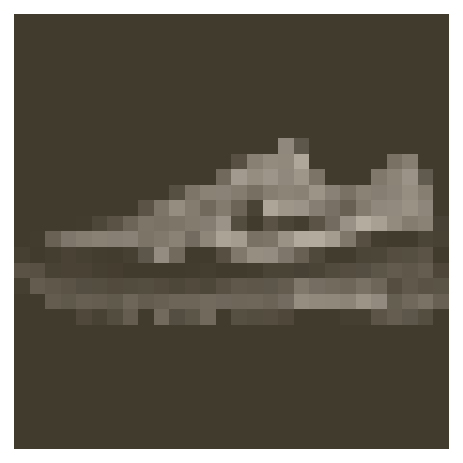

In [30]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [32]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128]) # (Input, Output, Hidden Layers)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.715..  Test Loss: 0.992..  Test Accuracy: 0.679
Epoch: 1/2..  Training Loss: 1.012..  Test Loss: 0.733..  Test Accuracy: 0.727
Epoch: 1/2..  Training Loss: 0.861..  Test Loss: 0.698..  Test Accuracy: 0.746
Epoch: 1/2..  Training Loss: 0.783..  Test Loss: 0.689..  Test Accuracy: 0.722
Epoch: 1/2..  Training Loss: 0.744..  Test Loss: 0.618..  Test Accuracy: 0.760
Epoch: 1/2..  Training Loss: 0.718..  Test Loss: 0.623..  Test Accuracy: 0.758
Epoch: 1/2..  Training Loss: 0.709..  Test Loss: 0.584..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.651..  Test Loss: 0.571..  Test Accuracy: 0.784
Epoch: 1/2..  Training Loss: 0.668..  Test Loss: 0.568..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.655..  Test Loss: 0.563..  Test Accuracy: 0.795
Epoch: 1/2..  Training Loss: 0.649..  Test Loss: 0.562..  Test Accuracy: 0.795
Epoch: 1/2..  Training Loss: 0.658..  Test Loss: 0.522..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.663..  Test Loss: 0.5

## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

***The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.***

In [34]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [37]:
# Store the weights and biasses of hidden layers
torch.save(model.state_dict(), 'checkpoint.pth')

In [39]:
# Now Load the saved model

state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [40]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

In [42]:
# # Try this
# model = fc_model.Network(784, 10, [400, 200, 100])
# # This will throw an error because the tensor sizes are wrong!
# model.load_state_dict(state_dict)

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [44]:
# The model will assume a hidden layer architect base by default, if we want to change the 
# hidden layer dimensions, we should manually save the size. In this case, [400, 200, 100]

checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints.

In [45]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [46]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
